In [9]:
%matplotlib inline
import numpy as np
import pandas as pd
from astropy.io import fits
from astropy.visualization import PercentileInterval, AsinhStretch
from astropy.wcs import utils
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.wcs import WCS
from astropy import units as u
from astropy.coordinates import SkyCoord
from spectral_cube import SpectralCube
from PIL import Image
from io import BytesIO
import requests
from spectral_cube import BooleanArrayMask
from astropy.visualization import ZScaleInterval

In [169]:
def geturl(ra, dec, size=240, output_size=None, filters="grizy", format="jpg", color=False):
    
    """Get URL for images in the table
    
    ra, dec = position in degrees
    size = extracted image size in pixels (0.25 arcsec/pixel)
    output_size = output (display) image size in pixels (default = size).
                  output_size has no effect for fits format images.
    filters = string with filters to include
    format = data format (options are "jpg", "png" or "fits")
    color = if True, creates a color image (only for jpg or png format).
            Default is return a list of URLs for single-filter grayscale images.
    Returns a string with the URL
    """
    service = "https://ps1images.stsci.edu/cgi-bin/ps1filenames.py"
    url = ("{service}?ra={ra}&dec={dec}&size={size}&format=fits"
           "&filters={filters}").format(**locals())
    table = Table.read(url, format='ascii')
    url = ("https://ps1images.stsci.edu/cgi-bin/fitscut.cgi?"
           "ra={ra}&dec={dec}&size={size}&format={format}").format(**locals())
    if output_size:
        url = url + "&output_size={}".format(output_size)
    # sort filters from red to blue
    flist = ["yzirg".find(x) for x in table['filter']]
    table = table[np.argsort(flist)]
    if color:
        if len(table) > 3:
            # pick 3 filters
            table = table[[0,len(table)//2,len(table)-1]]
        for i, param in enumerate(["red","green","blue"]):
            url = url + "&{}={}".format(param,table['filename'][i])
    else:
        urlbase = url + "&red="
        url = []
        for filename in table['filename']:
            url.append(urlbase+filename)
    print(url)
    return url

def get_opt(new_wcs, ra_pix=1030, dec_pix=1030, size_pix=100):
    d_width = 0.001666666707*u.deg
    ex_co_ords = utils.pixel_to_skycoord(ra_pix, dec_pix, new_wcs).to_string().split(" ")
    pix_size = int((size_pix*d_width.to(u.arcsec))/(0.25*u.arcsec))
    fitsurl = geturl(float(ex_co_ords[0]), float(ex_co_ords[1]), size=pix_size, filters="i", format="fits")
    fh = fits.open(fitsurl[0])
    fim = fh[0].data
    # replace NaN values with zero for display
    fim[np.isnan(fim)] = 0.0
    # set contrast to something reasonable
    transform = AsinhStretch() + PercentileInterval(99.5)
    bfim = transform(fim)
    fh[0].data = bfim
    return fh[0]

# Let's find a plausible galaxy

In [306]:
hi_data = fits.open("../data/orig_mosaics/1245mosC.derip.fits")
hi_data[0].header['CTYPE3'] = 'FREQ'
hi_data[0].header['CUNIT3'] = 'Hz'
hi_wcs = WCS(hi_data[0])
spec_cube = SpectralCube.read(hi_data)
hi_data.close()
sofia_cat_df = pd.read_csv("../results/loud_SOFIA_catalog.txt", index_col=0)
sof_data = fits.getdata("../data/sofia_output/sofia_loud_1245mosC_mask.fits")

66


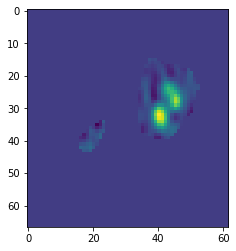

In [444]:
subset = sofia_cat_df[(sofia_cat_df.mos_name=="1245mosC") & ~sofia_cat_df.true_positive_mocks]
for i, row in subset.iterrows():
    if row.label == 66:
        print(row.label)
        masked = spec_cube.unmasked_data[int(row['centroid-0']), row['bbox-1']:row['bbox-4'], row['bbox-2']:row['bbox-5']]*sof_data[int(row['centroid-0']), row['bbox-1']:row['bbox-4'], row['bbox-2']:row['bbox-5']]
        plt.imshow(masked)
        plt.show()
        break

## Look at masked moment 0 map

In [332]:
def get_mom_masked(spec_cube, row, order=0):
    subcube = spec_cube[row['bbox-0']:row['bbox-3'], row['bbox-1']-int(row.nx*0.5):row['bbox-4']+int(row.nx*0.5), row['bbox-2']-int(row.ny*0.5):row['bbox-5']+int(row.ny*0.5)]
    det_subcube = sof_data[row['bbox-0']:row['bbox-3'], row['bbox-1']-int(row.nx*0.5):row['bbox-4']+int(row.nx*0.5), row['bbox-2']-int(row.ny*0.5):row['bbox-5']+int(row.ny*0.5)]
    det_subcube[:, :int(row.nx*0.5)] = 0
    det_subcube[:, :, :int(row.ny*0.5)] = 0
    det_subcube[:, -int(row.nx*0.5):] = 0
    det_subcube[:, :, -int(row.ny*0.5):] = 0
    masked = SpectralCube(subcube.unmasked_data[:]*det_subcube, wcs=subcube.wcs)
    moment_0 = masked.with_spectral_unit(u.Hz).moment(order=order)
    return moment_0

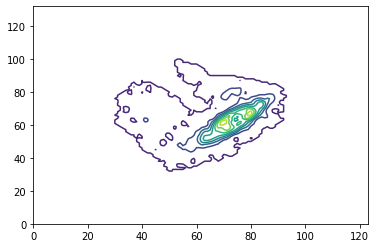

In [334]:
moment_0 = get_mom_masked(spec_cube, row)
plt.contour(moment_0)
plt.show()

## Retrieve galaxy info

['https://ps1images.stsci.edu/cgi-bin/fitscut.cgi?ra=29.1747&dec=34.174&size=3192&format=fits&red=/rings.v3.skycell/2015/053/rings.v3.skycell.2015.053.stk.i.unconv.fits']


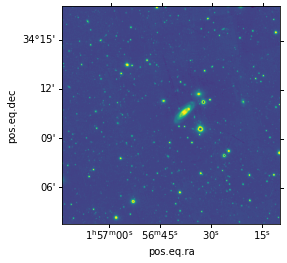

In [319]:
gal = get_opt(moment_0.wcs, ra_pix=moment_0.shape[0]/2, dec_pix=moment_0.shape[1]/2, size_pix=np.max(moment_0.shape))
ax = plt.subplot(projection=WCS(gal.header))
ax.imshow(gal.data, origin='lower')
plt.show()

## Overlay HI on optical data

In [387]:
subcube = spec_cube[row['bbox-0']:row['bbox-3'], row['bbox-1']-int(row.nx*0.5):row['bbox-4']+int(row.nx*0.5), row['bbox-2']-int(row.ny*0.5):row['bbox-5']+int(row.ny*0.5)]
masked_moment_0 = get_mom_masked(spec_cube, row)
unmasked_moment_0 = subcube.with_spectral_unit(u.Hz).moment(order=0)


In [388]:
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

def Gauss(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

def two_gaussians(x, h1, c1, w1, h2, c2, w2):
    return Gauss(x, h1, c1, w1) + Gauss(x, h2, c2, w2)

def fit_gauss(subcube, ax):
    x = np.arange(subcube.shape[0])
    y = [np.nansum(subcube[k]) for k in range(subcube.shape[0])]
    ax.plot(x, y, 'b+:', label='data')
    try:
        # weighted arithmetic mean (corrected - check the section below)
        peaks, properties = find_peaks(y, distance=25)
        peak_x = [x[y == sorted(np.array(y)[peaks])[-2:][0]][0], x[y == sorted(np.array(y)[peaks])[-2:][1]][0]]
        peak_y = sorted(np.array(y)[peaks])[-2:]
        sigma1 = np.sqrt(sum(y * (x - peak_x[0])**2) / sum(y))
        sigma2 = np.sqrt(sum(y * (x - peak_x[1])**2) / sum(y))
        popt, pcov = curve_fit(two_gaussians, x, y, p0=[
            peak_y[0], peak_x[0], sigma1,
            peak_y[1], peak_x[1], sigma2])
        residuals = y- two_gaussians(x, *popt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y-np.mean(y))**2)
        r_squared = 1 - (ss_res / ss_tot)
        ax.plot(x, two_gaussians(x, *popt), 'g-', label='fit')
    except:
        r_squared = np.nan
    return

/usr/local/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


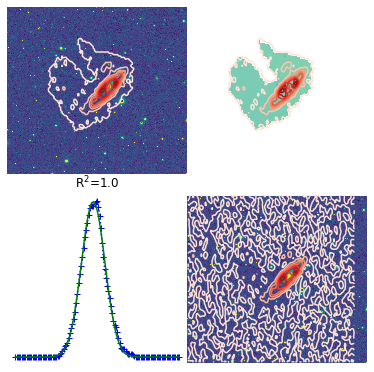

In [410]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(2, 2, 1, projection=masked_moment_0.wcs)
ax.contour(masked_moment_0, zorder=2, origin='lower', cmap="Reds")
ax.imshow(gal.data, transform=ax.get_transform(WCS(gal.header)), zorder=0, origin='lower')
# ax.imshow(masked_moment_1.value, zorder=1, origin='lower', alpha=0.6)
# ax.set_xlabel("Right Ascension", fontsize=20)
# ax.set_ylabel("Declination", fontsize=20)
ax.axis('off')
ax.set_xlim((0,masked_moment_0.shape[0]))
ax.set_ylim((0,masked_moment_0.shape[1]))
# plt.show()

ax1 = fig.add_subplot(2, 2, 4, projection=unmasked_moment_0.wcs)
ax1.axis('off')
ax1.contour(unmasked_moment_0, zorder=1, origin='lower', cmap="Reds")
ax1.imshow(gal.data, transform=ax1.get_transform(WCS(gal.header)), zorder=0, origin='lower')
ax1.set_xlim((0,unmasked_moment_0.shape[0]))
ax1.set_ylim((0,unmasked_moment_0.shape[1]))

ax2 = fig.add_subplot(2, 2, 2, projection=masked_moment_0.wcs)
ax2.axis('off')
ax2.contour(masked_moment_0, zorder=1, origin='lower', cmap="Reds")
ax2.imshow(masked_moment_1.value, zorder=0, origin='lower', alpha=0.6)
ax2.set_xlim((0,unmasked_moment_0.shape[0]))
ax2.set_ylim((0,unmasked_moment_0.shape[1]))

ax3 = fig.add_subplot(2, 2, 3)
ax3.axis('off')
fit_gauss(masked_moment_0.hdu.data, ax3)

fig.tight_layout(pad=0)

## Try with catalog of false positives

In [419]:

def overlay_hi(row):
    max_size = np.max([row.nx, row.ny])
    dx = int(max_size*0.5)
    subcube = spec_cube[row['bbox-0']:row['bbox-3'], row['bbox-1']-dx:row['bbox-4']+dx, row['bbox-2']-dx:row['bbox-5']+dx]
    det_subcube = sof_data[row['bbox-0']:row['bbox-3'], row['bbox-1']-dx:row['bbox-4']+dx, row['bbox-2']-dx:row['bbox-5']+dx]
    det_subcube[:, :dx] = 0
    det_subcube[:, :, :dx] = 0
    det_subcube[:, -dx:] = 0
    det_subcube[:, :, -dx:] = 0
    masked = SpectralCube(subcube.unmasked_data[:]*det_subcube, wcs=subcube.wcs)
    masked_moment_0 = masked.with_spectral_unit(u.Hz).moment(order=0)
    masked_moment_1 = masked.with_spectral_unit(u.Hz).moment(order=1)
    unmasked_moment_0 = subcube.with_spectral_unit(u.Hz).moment(order=0)
    gal = get_opt(unmasked_moment_0.wcs, ra_pix=unmasked_moment_0.shape[0]/2, dec_pix=unmasked_moment_0.shape[1]/2, size_pix=np.max(unmasked_moment_0.shape))

    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(2, 2, 1, projection=masked_moment_0.wcs)
    ax.contour(masked_moment_0, zorder=2, origin='lower', cmap="Reds")
    ax.imshow(gal.data, transform=ax.get_transform(WCS(gal.header)), zorder=0, origin='lower')
    # ax.imshow(masked_moment_1.value, zorder=1, origin='lower', alpha=0.6)
    # ax.set_xlabel("Right Ascension", fontsize=20)
    # ax.set_ylabel("Declination", fontsize=20)
    ax.axis('off')
    ax.set_xlim((0,masked_moment_0.shape[0]))
    ax.set_ylim((0,masked_moment_0.shape[1]))
    # plt.show()

    ax1 = fig.add_subplot(2, 2, 4, projection=unmasked_moment_0.wcs)
    ax1.axis('off')
    ax1.contour(unmasked_moment_0, zorder=1, origin='lower', cmap="Reds")
    ax1.imshow(gal.data, transform=ax1.get_transform(WCS(gal.header)), zorder=0, origin='lower')
    ax1.set_xlim((0,unmasked_moment_0.shape[0]))
    ax1.set_ylim((0,unmasked_moment_0.shape[1]))

    ax2 = fig.add_subplot(2, 2, 2, projection=masked_moment_0.wcs)
    ax2.axis('off')
    ax2.contour(masked_moment_0, zorder=1, origin='lower', cmap="Reds")
    ax2.imshow(masked_moment_1.value, zorder=0, origin='lower', alpha=0.6)
    ax2.set_xlim((0,unmasked_moment_0.shape[0]))
    ax2.set_ylim((0,unmasked_moment_0.shape[1]))

    ax3 = fig.add_subplot(2, 2, 3)
    ax3.axis('off')
    fit_gauss(unmasked_moment_0.hdu.data, ax3)

    fig.tight_layout(pad=0)
    plt.show()
#     plt.savefig("test.png")

In [445]:
max_size = np.max([row.nx, row.ny])
dx = int(max_size*0.5)
subcube = spec_cube[row['bbox-0']:row['bbox-3'], row['bbox-1']-dx:row['bbox-4']+dx, row['bbox-2']-dx:row['bbox-5']+dx]
det_subcube = sof_data[row['bbox-0']:row['bbox-3'], row['bbox-1']-dx:row['bbox-4']+dx, row['bbox-2']-dx:row['bbox-5']+dx]
det_subcube[:, :dx] = 0
det_subcube[:, :, :dx] = 0
det_subcube[:, -dx:] = 0
det_subcube[:, :, -dx:] = 0
masked = SpectralCube(subcube.unmasked_data[:]*det_subcube, wcs=subcube.wcs)
masked_moment_0 = masked.with_spectral_unit(u.Hz).moment(order=0)
masked_moment_1 = masked.with_spectral_unit(u.Hz).moment(order=1)
unmasked_moment_0 = subcube.with_spectral_unit(u.Hz).moment(order=0)
gal = get_opt(unmasked_moment_0.wcs, ra_pix=unmasked_moment_0.shape[0]/2, dec_pix=unmasked_moment_0.shape[1]/2, size_pix=np.max(unmasked_moment_0.shape))

/usr/local/lib/python3.8/site-packages/spectral_cube/_moments.py:168: RuntimeWarning: invalid value encountered in true_divide
  return (np.nansum(data * pix_cen, axis=axis) /


['https://ps1images.stsci.edu/cgi-bin/fitscut.cgi?ra=29.1787&dec=34.1773&size=3192&format=fits&red=/rings.v3.skycell/2015/053/rings.v3.skycell.2015.053.stk.i.unconv.fits']


66


/usr/local/lib/python3.8/site-packages/spectral_cube/_moments.py:168: RuntimeWarning: invalid value encountered in true_divide
  return (np.nansum(data * pix_cen, axis=axis) /


['https://ps1images.stsci.edu/cgi-bin/fitscut.cgi?ra=29.1787&dec=34.1773&size=3192&format=fits&red=/rings.v3.skycell/2015/053/rings.v3.skycell.2015.053.stk.i.unconv.fits']


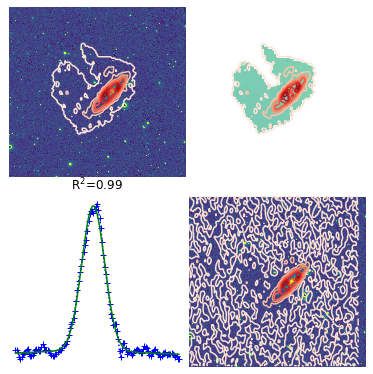

93


/usr/local/lib/python3.8/site-packages/spectral_cube/_moments.py:168: RuntimeWarning: invalid value encountered in true_divide
  return (np.nansum(data * pix_cen, axis=axis) /


['https://ps1images.stsci.edu/cgi-bin/fitscut.cgi?ra=29.2138&dec=33.0121&size=1560&format=fits&red=/rings.v3.skycell/2015/023/rings.v3.skycell.2015.023.stk.i.unconv.fits']


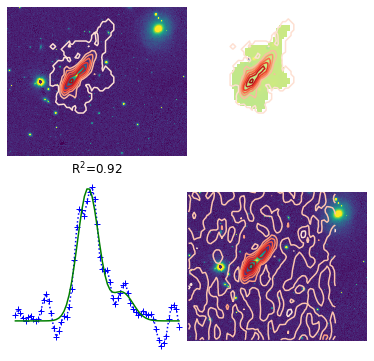

In [420]:
subset = sofia_cat_df[(sofia_cat_df.mos_name=="1245mosC") & ~sofia_cat_df.true_positive_mocks]
for i, row in subset.iterrows():
    if (row.label==66) | (row.label==93):
        print(row.label)
        overlay_hi(row)